In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from datetime import datetime

In [12]:
#load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

In [13]:
# Convert dates to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])


In [14]:
def create_customer_features():
    """Create features for clustering"""

    # Transaction-based features
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'Quantity': ['sum', 'mean'],
        'TotalValue': ['sum', 'mean', 'std'],
        'Price': ['mean', 'min', 'max']
    }).round(2)

    # Flatten column names
    transaction_features.columns = [
        'transaction_count',
        'total_quantity', 'avg_quantity',
        'total_spend', 'avg_spend', 'std_spend',
        'avg_price', 'min_price', 'max_price'
    ]

    # Calculate recency, frequency, monetary (RFM)
    last_transaction_date = transactions_df['TransactionDate'].max()

    rfm = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (last_transaction_date - x.max()).days,  # Recency
        'TransactionID': 'count',  # Frequency
        'TotalValue': 'sum'  # Monetary
    }).rename(columns={
        'TransactionDate': 'recency',
        'TransactionID': 'frequency',
        'TotalValue': 'monetary'
    })

    # Product category preferences
    category_preferences = transactions_df.merge(
        products_df[['ProductID', 'Category']],
        on='ProductID'
    ).groupby(['CustomerID', 'Category'])['TransactionID'].count().unstack(
        fill_value=0
    )

    # Calculate account age
    customers_df['account_age'] = (
        pd.Timestamp.now() - customers_df['SignupDate']
    ).dt.days

    # One-hot encode region
    region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')

    # Combine all features
    customer_features = customers_df[['CustomerID']].merge(
        transaction_features,
        left_on='CustomerID',
        right_index=True,
        how='left'
    )

    customer_features = customer_features.merge(
        rfm,
        left_on='CustomerID',
        right_index=True,
        how='left'
    )

    customer_features = customer_features.merge(
        category_preferences,
        left_on='CustomerID',
        right_index=True,
        how='left'
    )

    customer_features = customer_features.merge(
        customers_df[['CustomerID', 'account_age']],
        on='CustomerID',
        how='left'
    )

    customer_features = customer_features.merge(
        region_dummies,
        left_index=True,
        right_index=True,
        how='left'
    )

    # Fill NaN values
    customer_features = customer_features.fillna(0)

    return customer_features

In [15]:
def find_optimal_clusters(features, max_clusters=10):
    """Find optimal number of clusters using elbow method and DB Index"""

    inertias = []
    db_scores = []
    silhouette_scores = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)

        inertias.append(kmeans.inertia_)
        db_scores.append(davies_bouldin_score(features, kmeans.labels_))
        silhouette_scores.append(silhouette_score(features, kmeans.labels_))

    # Plot elbow curve
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(range(2, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    plt.subplot(1, 3, 2)
    plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index')

    plt.subplot(1, 3, 3)
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')

    plt.tight_layout()
    plt.show()

    return db_scores, silhouette_scores

In [16]:
def perform_clustering(features, n_clusters):
    """Perform K-means clustering"""

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    return kmeans, clusters

In [17]:
def analyze_clusters(features, clusters, feature_names):
    """Analyze cluster characteristics"""

    cluster_df = pd.DataFrame(features, columns=feature_names)
    cluster_df['Cluster'] = clusters

    # Calculate cluster statistics
    cluster_stats = cluster_df.groupby('Cluster').agg(['mean', 'std'])

    # Calculate cluster sizes
    cluster_sizes = cluster_df['Cluster'].value_counts().sort_index()

    return cluster_stats, cluster_sizes

In [23]:
def visualize_clusters(features, clusters, feature_names):
    """Create visualizations of the clusters"""

    # PCA for dimensionality reduction
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # Plot clusters
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap='viridis')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('Customer Segments Visualization')
    plt.colorbar(scatter)
    plt.show()

    # Feature importance
    feature_importance = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=feature_names
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(feature_importance, cmap='RdBu', center=0)
    plt.title('Feature Importance in Principal Components')
    plt.show()

# Main execution
print("Creating customer features...")
customer_features = create_customer_features()

Creating customer features...



Finding optimal number of clusters...


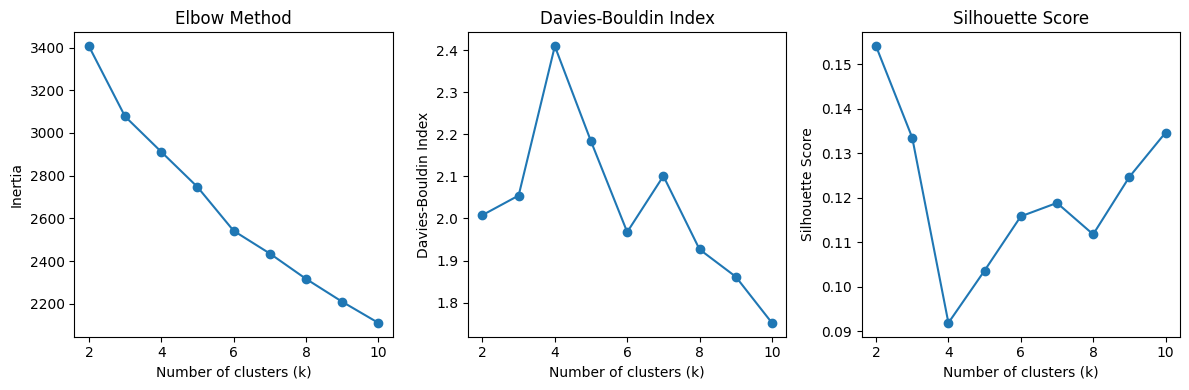

In [24]:
# Prepare features for clustering
feature_columns = customer_features.columns.drop('CustomerID')
features = StandardScaler().fit_transform(customer_features[feature_columns])

print("\nFinding optimal number of clusters...")
db_scores, silhouette_scores = find_optimal_clusters(features)



Performing clustering with 5 clusters...

Analyzing clusters...

Cluster sizes:
Cluster
0    37
1    49
2    18
3    32
4    64
Name: count, dtype: int64

Davies-Bouldin Index: 2.183161601459598
Silhouette Score: 0.10363983851148972

Creating visualizations...


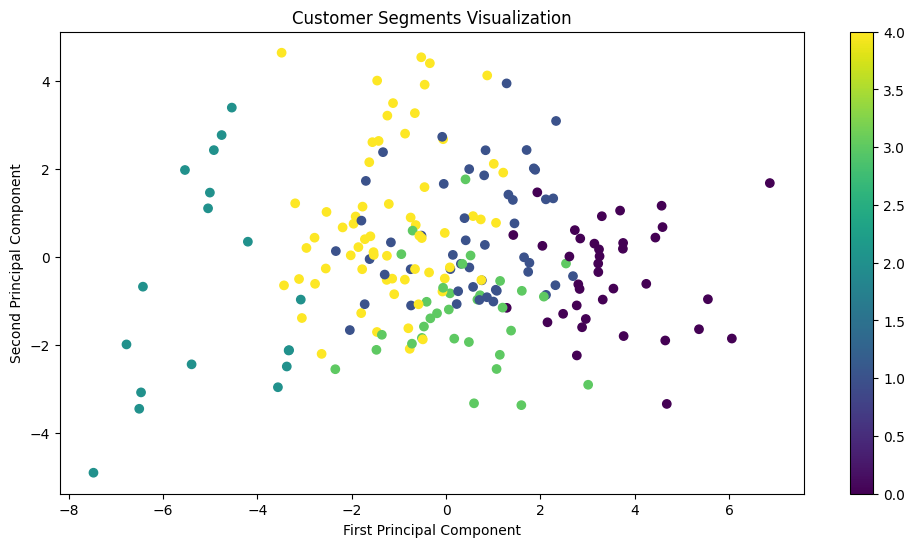

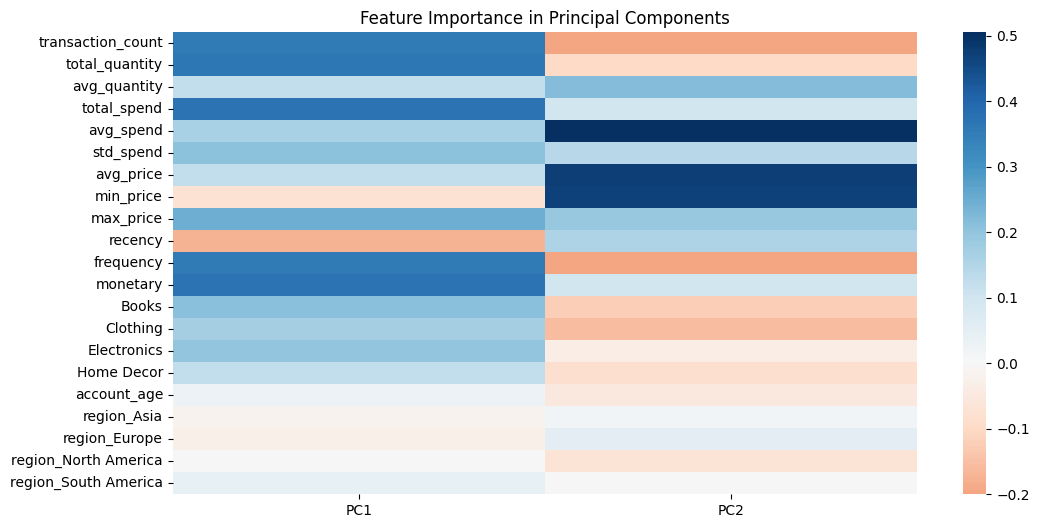

In [25]:
# Choose optimal number of clusters (example: 5)
n_clusters = 5
print(f"\nPerforming clustering with {n_clusters} clusters...")
kmeans, clusters = perform_clustering(features, n_clusters)

print("\nAnalyzing clusters...")
cluster_stats, cluster_sizes = analyze_clusters(features, clusters, feature_columns)

print("\nCluster sizes:")
print(cluster_sizes)

print("\nDavies-Bouldin Index:", davies_bouldin_score(features, clusters))
print("Silhouette Score:", silhouette_score(features, clusters))

print("\nCreating visualizations...")
visualize_clusters(features, clusters, feature_columns)

In [26]:
# Save results
results = customer_features[['CustomerID']].copy()
results['Cluster'] = clusters
results.to_csv('customer_segments.csv', index=False)